## Tunning Hyperparameters:
    
1. Tunning Num. Filters\
    1.1. [Tunning Num. Filters as Pyramidal Shape](#pyramidal) \
    1.2. [Tunning Num. Filters as Ramp Shape](#ramp)
2. [Tunning Kernel's sizes](#kernel)
3. [Tunning Optimizer Hyperparameters](#optimizer)\
    3.1. [Momentum](#momentum) \
    3.2. [Weight Decay](#weight_decay) \
    3.3. [Lerning Rate](#lr)
4. [Tunning Training Hyperparameters](#training_hps)
5. [Testing normalization impact](#withnorm)

In [1]:
# setting up paths
from sys import path, stdout
from os import environ

path.append("/home/leandrosantos/IC-AutoEncoder/")
path.append("/home/leandrosantos/IC-AutoEncoder/modules/")
path.append("/home/leandrosantos/IC-AutoEncoder/src/modules/")

# setting device
environ["CUDA_VISIBLE_DEVICES"] = "1"

# setting seeds for reproduce
import tensorflow as tf
import random as rd

seed = 3344323
rd.seed(seed)
tf.random.set_seed(seed)

2023-11-06 16:55:11.183321: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# importing libraries

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import Sequential
from modules.CustomLosses import L3SSIM

from modules.misc import ssim_metric
from modules.ImageMetrics.metrics import three_ssim, psnrb

import keras_tuner as kt

from tensorflow.keras.callbacks import TensorBoard, BackupAndRestore

In [3]:
# Fetching dataset

from modules.DataMod import DataSet
import cupy

cifar, tiny, noised_dataset = DataSet(), DataSet(), DataSet()

cifar.load_rafael_cifar_10_noise_data()
tiny.load_rafael_tinyImagenet_64x64_noise_data()
print("Cifar and tiny loaded.")

noised_dataset.load_cifar_and_tiny(cifar, tiny)
noised_dataset.add_gaussian_noise(dist_normal = 0.3) # adds gaussian noise
print("Dataset created.")

cupy.get_default_memory_pool().free_all_blocks()
cupy.get_default_pinned_memory_pool().free_all_blocks()

del cifar, tiny

Cifar and tiny loaded.
Dataset created.


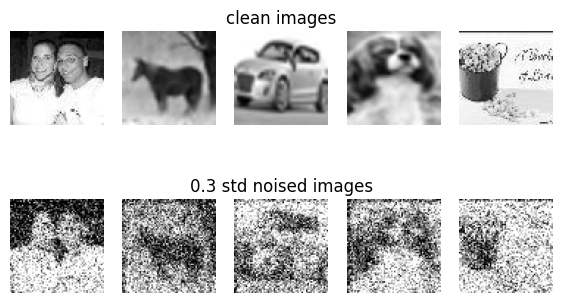

In [4]:
# seeing the noised datasets 

from matplotlib import pyplot as plt

plt.figure(figsize=(7, 4))
columns = 5
rows = 2

magic_number = [rd.randint(0, noised_dataset.x_train.shape[0]-1) for x in range(columns)]

plt.subplot(rows, columns, 3)
plt.title("clean images")
plt.subplot(rows, columns, 8)
plt.title("0.3 std noised images")

for idx in range(columns):
    plt.subplot(rows, columns, idx+1)
    plt.imshow(noised_dataset.y_train[magic_number[idx]], cmap="gray")
    plt.axis("off")
    plt.subplot(rows, columns, idx+columns+1)
    plt.imshow(noised_dataset.x_train[magic_number[idx]], cmap="gray")
    plt.axis("off")

<a id='pyramidal'></a>

## Tunning Num. Filters as Pyramidal Shape

In [5]:
# Defining model

from keras_tuner import HyperParameters

def filters_tunning(hp : HyperParameters):
    
    model = Sequential(name="autoEncoder")
    
    ext_kernel_sz = 4
    int_kernel_sz = 3
    
    l1_filters = hp.Int('conv1_filters', min_value = 10, max_value = 30, step=10)
    l2_filters = hp.Int('conv2_filters', min_value=30, max_value=60, step=10)
    l3_filters = hp.Int('conv3_filters', min_value=60, max_value=90, step=10)
    l4_filters = hp.Int('conv4_filters', min_value=90, max_value=120, step=10)
    l5_filters = hp.Int('conv5_filters', min_value=120, max_value=150, step=10)
    l6_filters = hp.Int('conv6_filters', min_value=150, max_value=200, step=15)
    
    l7_filters = hp.Int('conv7_filters', min_value=150, max_value=200, step=10)
    l8_filters = hp.Int('conv8_filters', min_value=120, max_value=150, step=10)
    l9_filters = hp.Int('conv9_filters', min_value=90, max_value=120, step=10)
    l10_filters = hp.Int('conv10_filters', min_value=60, max_value=90, step=10)
    l11_filters = hp.Int('conv11_filters', min_value=35, max_value=60, step=5)
    l12_filters = hp.Int('conv12_filters', min_value=20, max_value=35, step=5)
    l13_filters = hp.Int('conv13_filters', min_value=5, max_value=20, step=5)
    
    model.add(Conv2D(input_shape=(64,64,1), filters =l1_filters , kernel_size = ext_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = l2_filters, kernel_size = ext_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters = l3_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = l4_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D())

    model.add(Conv2D(filters = l5_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = l6_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())

    model.add(Conv2D(filters = l7_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = l8_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(UpSampling2D())

    model.add(Conv2D(filters = l9_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = l10_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(UpSampling2D())
    model.add(BatchNormalization())

    model.add(Conv2D(filters = l11_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = l12_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(UpSampling2D())
    model.add(BatchNormalization())

    model.add(Conv2D(filters = l13_filters, kernel_size = ext_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 1, kernel_size = ext_kernel_sz, padding = 'same', activation = 'relu'))
                     
    model.compile(optimizer = Adam(), loss = L3SSIM(), metrics=[ssim_metric])

    return model

In [6]:
tuner_pyr = kt.BayesianOptimization(hypermodel=filters_tunning, objective = kt.Objective('val_ssim_metric', 'max'),
                          max_trials=40, seed = seed, max_retries_per_trial = 1, max_consecutive_failed_trials = 5,
                          directory="tunning", project_name="pyramidal_filters", overwrite=False)

tuner_pyr.search(noised_dataset.x_train, noised_dataset.y_train, epochs = 10, batch_size = 20, validation_data=(noised_dataset.x_test, noised_dataset.y_test), callbacks=[TensorBoard('./tunning/pyramidal_filters/tensorboard_logs'), BackupAndRestore(backup_dir='./tunning/backup', save_freq=500)])

INFO:tensorflow:Reloading Tuner from tunning/pyramidal_filters/tuner0.json
INFO:tensorflow:Oracle triggered exit


<a id='ramp'></a>

## Tunning Num. Filters as Ramp Shape

In [7]:
# Defining model

from keras_tuner import HyperParameters

def filters_tunning(hp : HyperParameters):
    
    model = Sequential(name="autoEncoder")
    
    ext_kernel_sz = 4
    int_kernel_sz = 3
    
    l1_filters = hp.Int('conv1_filters', min_value=5, max_value=15, step=5)
    l2_filters = hp.Int('conv2_filters', min_value=15, max_value=30, step=5)
    l3_filters = hp.Int('conv3_filters', min_value=30, max_value=50, step=10)
    l4_filters = hp.Int('conv4_filters', min_value=50, max_value=75, step=10)
    l5_filters = hp.Int('conv5_filters', min_value=75, max_value=100, step=10)
    l6_filters = hp.Int('conv6_filters', min_value=100, max_value=125, step=10)
    l7_filters = hp.Int('conv7_filters', min_value=125, max_value=150, step=10)
    l8_filters = hp.Int('conv8_filters', min_value=150, max_value=175, step=10)
    l9_filters = hp.Int('conv9_filters', min_value=175, max_value=200, step=10)
    l10_filters = hp.Int('conv10_filters', min_value=200, max_value=225, step=10)
    l11_filters = hp.Int('conv11_filters', min_value=225, max_value=250, step=10)
    l12_filters = hp.Int('conv12_filters', min_value=250, max_value=275, step=10)
    l13_filters = hp.Int('conv13_filters', min_value=275, max_value=300, step=10)
    
    model.add(Conv2D(input_shape=(64,64,1), filters=l1_filters , kernel_size = ext_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = l2_filters, kernel_size = ext_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters = l3_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = l4_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D())

    model.add(Conv2D(filters = l5_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = l6_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())

    model.add(Conv2D(filters = l7_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = l8_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(UpSampling2D())

    model.add(Conv2D(filters = l9_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = l10_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(UpSampling2D())
    model.add(BatchNormalization())

    model.add(Conv2D(filters = l11_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = l12_filters, kernel_size = int_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(UpSampling2D())
    model.add(BatchNormalization())

    model.add(Conv2D(filters = l13_filters, kernel_size = ext_kernel_sz, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 1, kernel_size = ext_kernel_sz, padding = 'same', activation = 'relu'))
                     
    model.compile(optimizer = Adam(), loss = L3SSIM(), metrics=[ssim_metric])

    return model

In [ ]:
tuner_ramp = kt.BayesianOptimization(hypermodel=filters_tunning, objective = kt.Objective('val_ssim_metric', 'max'),
                          max_trials=40, seed = seed, max_retries_per_trial = 1, max_consecutive_failed_trials = 5,
                          directory="tunning", project_name="ramp_filters", overwrite=False)

tuner_ramp.search(noised_dataset.x_train, noised_dataset.y_train, epochs = 10, batch_size = 20, validation_data=(noised_dataset.x_test, noised_dataset.y_test), callbacks=[TensorBoard('./tunning/ramp_filters/tensorboard_logs'), BackupAndRestore(backup_dir='./tunning/backup', save_freq=500)])

INFO:tensorflow:Reloading Tuner from tunning/ramp_filters/tuner0.json

Search: Running Trial #29

Value             |Best Value So Far |Hyperparameter
5                 |15                |conv1_filters
15                |25                |conv2_filters
30                |50                |conv3_filters
50                |60                |conv4_filters
75                |85                |conv5_filters
120               |120               |conv6_filters
145               |145               |conv7_filters
170               |150               |conv8_filters
195               |195               |conv9_filters
210               |200               |conv10_filters
235               |225               |conv11_filters
250               |250               |conv12_filters
295               |275               |conv13_filters

Epoch 1/10
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://gi

<a id='kernel'></a>

## Tunning Kernel's sizes

In [ ]:
# Defining model

from keras_tuner import HyperParameters

def kernel_tunning(hp : HyperParameters):
    
    model = Sequential(name="autoEncoder")
    
    step=1
    l1_kernel = hp.Int('conv1_kernel', min_value=2, max_value=8, step=step)
    l2_kernel = hp.Int('conv2_kernel', min_value=2, max_value=8, step=step)
    l3_kernel = hp.Int('conv3_kernel', min_value=2, max_value=8, step=step)
    l4_kernel = hp.Int('conv4_kernel', min_value=2, max_value=8, step=step)
    l5_kernel = hp.Int('conv5_kernel', min_value=2, max_value=8, step=step)
    l6_kernel = hp.Int('conv6_kernel', min_value=2, max_value=8, step=step)
    l7_kernel = hp.Int('conv7_kernel', min_value=2, max_value=8, step=step)
    l8_kernel = hp.Int('conv8_kernel', min_value=2, max_value=8, step=step)
    l9_kernel = hp.Int('conv9_kernel', min_value=2, max_value=8, step=step)
    l10_kernel = hp.Int('conv10_kernel', min_value=2, max_value=8, step=step)
    l11_kernel = hp.Int('conv11_kernel', min_value=2, max_value=8, step=step)
    l12_kernel = hp.Int('conv12_kernel', min_value=2, max_value=8, step=step)
    l13_kernel = hp.Int('conv13_kernel', min_value=2, max_value=8, step=step)
    l14_kernel = hp.Int('conv14_kernel', min_value=2, max_value=8, step=step)
    
    model.add(Conv2D(input_shape=(64,64,1), filters=l1_filters , kernel_size = l1_kernel, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = l2_filters, kernel_size = l2_kernel, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters = l3_filters, kernel_size = l3_kernel, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = l4_filters, kernel_size = l4_kernel, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D())

    model.add(Conv2D(filters = l5_filters, kernel_size = l5_kernel, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = l6_filters, kernel_size = l6_kernel, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())

    model.add(Conv2D(filters = l7_filters, kernel_size = l7_kernel, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = l8_filters, kernel_size = l8_kernel, padding = 'same', activation = 'relu'))
    model.add(UpSampling2D())

    model.add(Conv2D(filters = l9_filters, kernel_size = l9_kernel, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = l10_filters, kernel_size = l10_kernel, padding = 'same', activation = 'relu'))
    model.add(UpSampling2D())
    model.add(BatchNormalization())

    model.add(Conv2D(filters = l11_filters, kernel_size = l11_kernel, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = l12_filters, kernel_size = l12_kernel, padding = 'same', activation = 'relu'))
    model.add(UpSampling2D())
    model.add(BatchNormalization())

    model.add(Conv2D(filters = l13_filters, kernel_size = l13_kernel, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 1, kernel_size = l14_kernel, padding = 'same', activation = 'relu'))
                   
    model.compile(optimizer = Adam(), loss = L3SSIM(), metrics=[ssim_metric])

    return model

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 20 epochs

from Trainer import NetTrainer

trainer = NetTrainer(filters_tunning, noised_dataset, no_folds=1, hyperparams=best_hps, epochs=100, batch_size=20, tracking_metric="val_ssim_metric", logs_path="logs/num_filters_tunning/logs")
trainer.start_training()

In [ ]:
val_ssim_per_epoch = trainer.history.history['val_ssim_metric']
print(val_ssim_per_epoch)

# train x test accuracy

# model loss x ssim plot

# all 30 plots num_params x value got